# Motion planner cut in small pieces for easy debugging

In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import utm

from planning_utils import a_star, heuristic #, create_grid
from planning_tools import create_grid, create_grid_and_edges, prune_path, heuristic_func, find_start_goal
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local
from udacidrone.frame_utils import local_to_global

from skimage.morphology import medial_axis
from skimage.util import invert


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
colliders_file = 'colliders.csv'
with open(colliders_file) as f:
    latlon = f.readline().strip().split(',')
    lat0 = float(latlon[0].replace("lat0 ", ""))
    lon0 = float(latlon[1].replace("lon0 ", ""))
    print('lat: ', lat0)
    print('lon: ', lon0)



lat:  37.79248
lon:  -122.39745


-316.0 605.0
-445.0 476.0
921 921


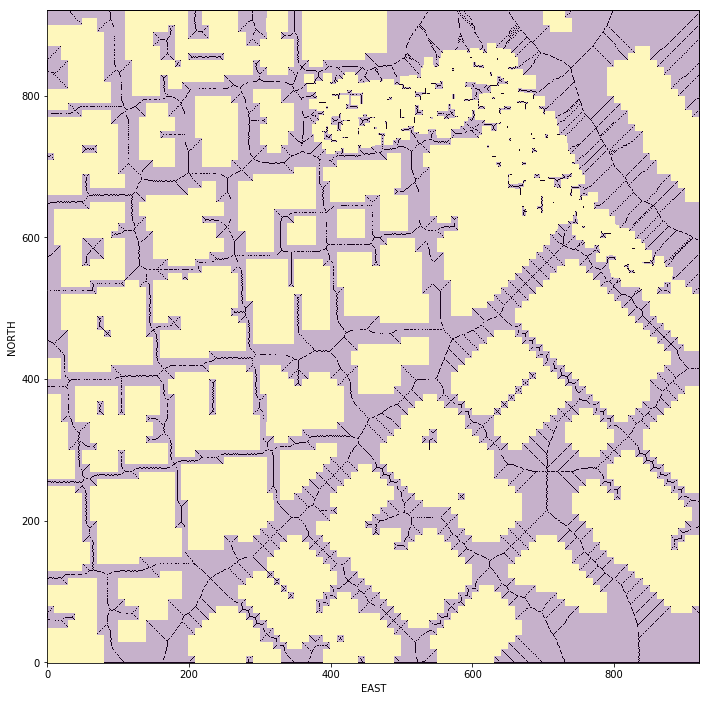

In [16]:
plt.rcParams['figure.figsize'] = 12, 12

data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
# print(data)
# Static drone altitude (meters)
drone_altitude = 5
# Minimum distance stay away from obstacle (meters)
safe_distance = 5

grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)
#grid, edges, north_offset, east_offset = create_grid_and_edges(data, drone_altitude, safe_distance)
skeleton = medial_axis(invert(grid))

# first show the midial grid
# equivalent to
# plt.imshow(np.flip(grid, 0))

plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
#plt.plot(grid_start[1], grid_start[0], 'rx')
#plt.plot(grid_goal[1], grid_goal[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()



    

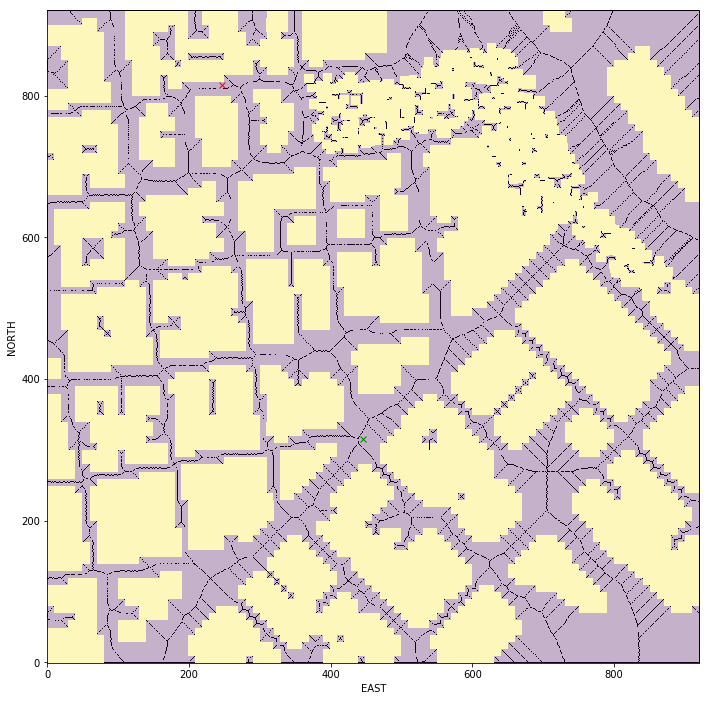

In [17]:

#set grid start and grid goal
# start to pos 1
grid_start = (316,445)
grid_goal  = (815, 246)

# from pos 1 to pos 2#
#grid_start = (815, 247)
#grid_goal = (427, 418)

# from pos 2 to pos 3
#grid_start = (426,418)
#grid_goal  = (388, 35)

# from pos 3 back to start
#grid_start = (387,35)
#rid_goal  = (316, 445)

plt.imshow(grid, origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
plt.plot(grid_start[1], grid_start[0], 'gx')
plt.plot(grid_goal[1], grid_goal[0], 'rx')


plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()



In [18]:
skel_start, skel_goal = find_start_goal(skeleton, grid_start, grid_goal)

print('original start and goal: ',grid_start, grid_goal)
print('start and goal on skeleton: ', skel_start, skel_goal)

original start and goal:  (316, 445) (815, 246)
start and goal on skeleton:  [320 441] [810 245]


start a-star search!
Found a path.
611 152674.14335160636
163


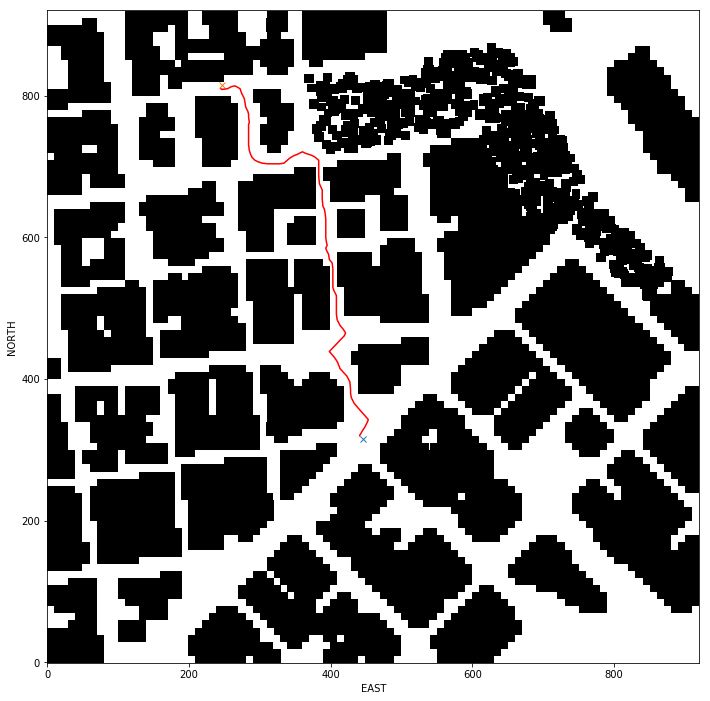

In [19]:
# a star search with midian grid

median_path, cost = a_star(invert(skeleton).astype(np.int), 
                    heuristic_func, 
                    tuple(skel_start), 
                    tuple(skel_goal))
print(len(median_path), cost)

pruned_path = prune_path(median_path)
print(len(pruned_path))

plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(grid_start[1], grid_start[0], 'x')
plt.plot(grid_goal[1], grid_goal[0], 'x')

pp = np.array(pruned_path)
plt.plot(pp[:, 1], pp[:, 0], 'r')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [ ]:
 waypoints = [[p[0] + north_offset, p[1] + east_offset, drone_altitude, 0] for p in pruned_path]
 print(waypoints)   

In [ ]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [ ]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)
        
    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)    

In [ ]:
    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        #----------------------------------------------------------------------------
        # CDA: HOME POSITION
        
        # TODO: read lat0, lon0 from colliders into floating point values
        # Open coliders.csv and read lat0 and lon0
        colliders_file = 'colliders.csv'

        with open(colliders_file) as f:
            latlon = f.readline().strip().split(',')
            lat0 = float(latlon[0].strip().strip('lat0'))
            lon0 = float(latlon[1].strip().strip('lon0'))
            
        # TODO: set home position to (lat0, lon0, 0)
        self.set_home_position(lat0, lon0, 0.)
    
        
        # CDA: END HOME POSITION
        #----------------------------------------------------------------------------

        #----------------------------------------------------------------------------
        # CDA: CURRENT POSITION
        # TODO: retrieve current global position
        current_global_position = [self._longitude, self._latitude, self._altitude]
        print('curent global position: ', current_global_position)
        # TODO: convert to current local position using global_to_local()
        #current_local_position = global_to_local(current_global_position,self.global_home)
        current_local_position = global_to_local(self.global_position,self.global_home)
        
        print('current local position: ', current_local_position)

        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # CDA: END CURRENT POSITION
        #----------------------------------------------------------------------------

        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        
        #----------------------------------------------------------------------------
        # CDA: START POINT
        # Define starting point on the grid (this is just grid center)
        # grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        north_start = int(current_local_position[0] + north_offset)
        east_start = int(current_local_position[1] + east_offset)
        print('current local position: ' , current_local_position)
        #grid_start = (north_start, east_start)
        grid_start = (int(current_local_position[0]), int(current_local_position[1]))

        # CDA: END START POINT
        #----------------------------------------------------------------------------
        
        #----------------------------------------------------------------------------
        # CDA: SET GOAL POINT
        # Set goal as some arbitrary position on the grid
        # grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert
        #1. goal_lat = float(37.796874)
        #2. goal_lat = float(37.793515)
        goal_lat = float(37.792829)
        #1. goal_lon = float(-122.399683)
        #2. goal_lon = float(-122.397632)
        goal_lon = float(-122.397526)
        goal = [goal_lon, goal_lat, self.global_home[2]]
        goal_position = global_to_local(goal, self.global_home)
        north_goal = int(goal_position[0] + north_offset)
        east_goal = int(goal_position[1] + east_start)
        #grid_goal = (-north_goal, -east_goal)
        grid_goal = (int(current_local_position[0] + 10), int(current_local_position[1] + 10))

        # CDA: END START POINT
        #----------------------------------------------------------------------------

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim
        self.send_waypoints()

In [ ]:
    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()




In [ ]:
if __name__ == "__main__":
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()

    #conn = MavlinkConnection('tcp:{0}:{1}'.format(args.host, args.port), timeout=60)
    conn = MavlinkConnection('tcp:127.0.0.1:5760',timeout=60)
    drone = MotionPlanning(conn)
    time.sleep(1)

    drone.start()
